In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sqla
from io import StringIO
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotnine as p9
from collections import Counter
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image 
plotly.tools.set_credentials_file(username='zhenhangliu', api_key='vNe3aFwBSfb1pV4LNLwO')
mapbox_access_token = 'pk.eyJ1IjoiemhlbmhhbmdsaXUiLCJhIjoiY2pvemZremhyMG1sOTN2cDRiMjJ4bmR0MSJ9.UHRGP-HIJHJJA7np0AxlbQ'
conn = sqla.create_engine('sqlite:///yelp.sqlite')

In [2]:
#preprocess bussiness data
business=pd.read_sql_table("business",conn)
business.replace("",np.nan,inplace=True)
#simplify category column by using the most important term
business.fillna({"categories":"Not Avaliable"},inplace=True)
business["categories"]=business.categories.str.replace(" ","")
category=business.categories.str.split(",")
category=category.apply(Counter)
combined_category=Counter()
for c in category:
    combined_category.update(c)
cate_count=pd.DataFrame.from_dict(combined_category,"index").reset_index().sort_values(0,ascending=False)
cate_count.columns=["name","count"]
simple_category=[]
for row in business.categories.str.split(","):
    for category in cate_count["name"]:
        if category in row:
            simple_category.append(category)
            break
business.categories=pd.Series(simple_category)

In [38]:
business.city.value_counts()[business.city.value_counts()>4000].sort_values(ascending=True)

Chandler       4272
Tempe          4492
Henderson      4815
Montréal       6045
Mesa           6239
Pittsburgh     6804
Calgary        7384
Scottsdale     8822
Charlotte      9204
Toronto       18233
Phoenix       18633
Las Vegas     28865
Name: city, dtype: int64

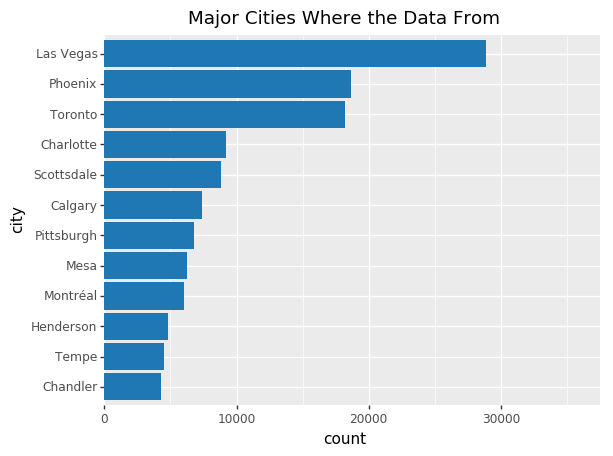

<ggplot: (-9223372029300750483)>

In [57]:
#which cities the major data from
major_count=business.city.value_counts()[business.city.value_counts(ascending=False)>4000].sort_values(ascending=True)
major_city=pd.DataFrame({"city":major_count.index,"count":major_count.values})
p9.ggplot(major_city,p9.aes(x="city",y="count"))+p9.geom_bar(stat="identity",fill="C0")+p9.coord_flip()\
    +p9.scale_x_discrete (limits =major_city.city)+p9.labs(title="Major Cities Where the Data From")\
    +p9.scale_y_continuous(expand=[0,0,0.3,0])

In [3]:
map_data=business[business["longitude"].notnull() & business["latitude"].notnull()]
data = [
    go.Scattermapbox(
        lat=map_data["latitude"],
        lon=map_data["longitude"],
        mode='markers',
        marker=dict(
            opacity = 0.3,
            size=7,
        ),
        text=map_data["name"]+"<br>Stars: "+map_data["stars"].astype(str)\
        +"<br>Review: "+map_data["review_count"].astype(str)+"<br>"+map_data["address"].fillna('')+"<br>"\
        +map_data["city"].fillna('')+","+map_data["state"].fillna('')+" "+map_data["postal_code"].fillna(''),
    ) 
]

layout = go.Layout(
    autosize=True,
    title="Business on Map",
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=map_data["latitude"].median(),
            lon=map_data["longitude"].median()
        ),
        pitch=0,
        zoom=2,
        style= 'mapbox://styles/zhenhangliu/cjp0dy6xg05rt2rod3gviy342'
    ),
    legend=dict(orientation="h")
)
fig=dict(data=data,layout=layout)
py.iplot(fig,filename="Yelp Data map 1")

/anaconda3/lib/python3.7/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/anaconda3/lib/python3.7/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:


In [4]:
map_data=business[business["longitude"].notnull() & business["latitude"].notnull()]
grouped_city=map_data[map_data["city"].notnull()].groupby("city")
def get_outlier(data):
    data.reset_index(drop=True,inplace=True)
    if len(data.index)>=10:
        number_neighbors=round(len(data.index)/10)
    elif len(data.index)<=2:
        data["outlier"]=1
        return data
    else:
        number_neighbors=len(data.index)
    LOF = LocalOutlierFactor(n_neighbors=number_neighbors,metric="euclidean",contamination=0.0004)
    outlier=pd.DataFrame(LOF.fit_predict(data[["latitude","longitude"]]))
    data.reset_index(inplace=True,drop=True)
    data["outlier"]=outlier
    data.index.name=None
    return data

map_data=grouped_city.apply(get_outlier)

data = [
    go.Scattermapbox(
        lat=business["latitude"],
        lon=business["longitude"],
        mode='markers',
        marker=dict(
            opacity = 0.3,
            size=7,
            color="#ff7f0e" if business["outlier"][0]==-1 else "#1f77b4"
        ),
        text=business["name"]+"<br>Stars: "+business["stars"].astype(str)\
        +"<br>Review: "+business["review_count"].astype(str)+"<br>"+business["address"].fillna('')+"<br>"\
        +business["city"].fillna('')+","+business["state"].fillna('')+" "+business["postal_code"].fillna(''),
        name="with Incorrect Geographic Information",
        showlegend=True if business["outlier"].iloc[0]==-1 else False,
    ) for business in [map_data[map_data["outlier"]==i] for i in map_data["outlier"].unique()[::-1]]
]

layout = go.Layout(
    autosize=True,
    title="Bussines with Incorrect Geographic Information Provided by Yelp",
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=map_data["latitude"].median(),
            lon=map_data["longitude"].median()
        ),
        pitch=0,
        zoom=0,
        style= 'mapbox://styles/zhenhangliu/cjp0dy6xg05rt2rod3gviy342'
    ),
    legend=dict(orientation="h")
)
fig=dict(data=data,layout=layout)
py.iplot(fig,filename="Yelp Data map2")

/anaconda3/lib/python3.7/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/anaconda3/lib/python3.7/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:


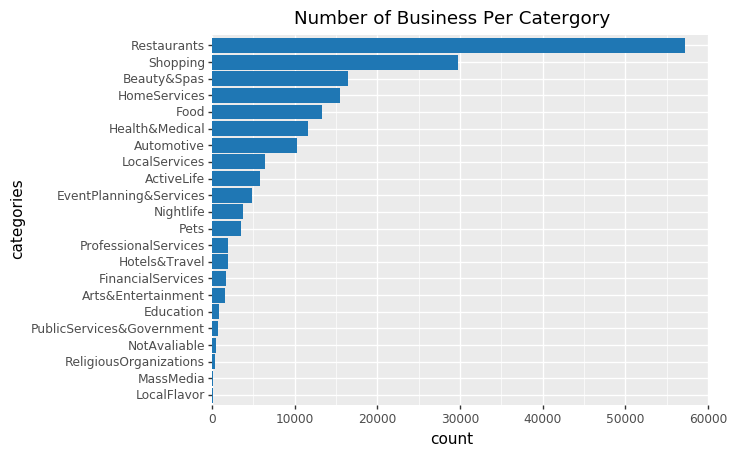

<ggplot: (7548308968)>

In [58]:
sorted_cate=business.categories.value_counts(ascending=True).index
p9.ggplot(business,p9.aes("categories"))+p9.geom_bar(fill="C0")+p9.coord_flip()\
    +p9.scale_x_discrete (limits =sorted_cate)+p9.labs(title="Number of Business Per Catergory")\
    +p9.scale_y_continuous(expand=[0,0],limits=[0,60000])

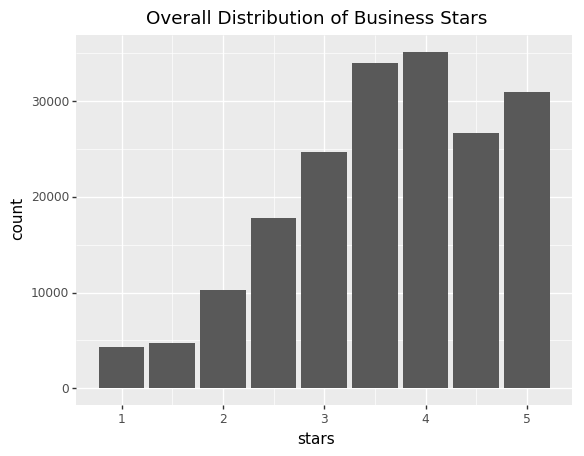

<ggplot: (-9223372029301181447)>

In [59]:
p9.ggplot(business,p9.aes("stars"))+p9.geom_bar()+p9.labs(title="Overall Distribution of Business Stars")

In [73]:
useful_stars=pd.read_sql_query("select business_id,stars,useful from review",conn)

In [96]:
useful_stars[useful_stars.useful>4]["useful"]="5+"

TypeError: '>' not supported between instances of 'str' and 'int'

In [102]:
(round(useful_stars.groupby(["business_id","useful"]).mean()*2)/2).reset_index("useful")

,useful,stars
business_id,,
--1UhMGODdWsrMastO9DZw,0,4.0
--1UhMGODdWsrMastO9DZw,1,4.5
--1UhMGODdWsrMastO9DZw,2,5.0
--1UhMGODdWsrMastO9DZw,5+,1.5
--6MefnULPED_I942VcFNA,0,3.0
--6MefnULPED_I942VcFNA,1,3.0
--6MefnULPED_I942VcFNA,2,2.5
--6MefnULPED_I942VcFNA,4,4.0
--6MefnULPED_I942VcFNA,5+,3.5


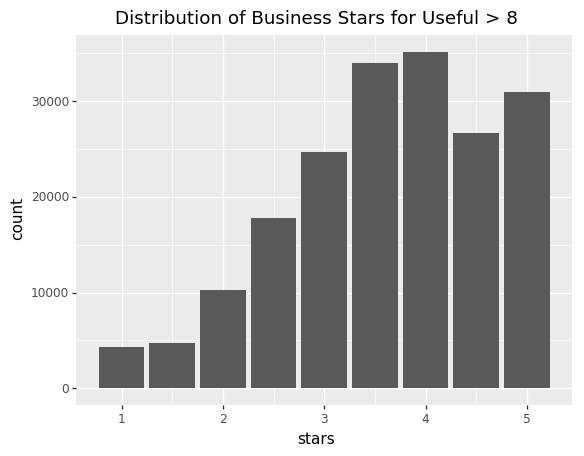

<ggplot: (-9223372029301783657)>

In [70]:
useful_stars=round(useful_stars.groupby("business_id").mean()*2)/2
p9.ggplot(useful_stars,p9.aes("stars"))+p9.geom_bar()+p9.labs(title="Distribution of Business Stars for Useful > 8")

In [64]:
onestar_review=pd.read_sql_query("select text from review  where stars=1",conn)

In [65]:
fivestar_review=pd.read_sql_query("select text from review  where stars=5",conn)

Text(0.5, 1.0, 'What is in Yelp Five Star Reviews ?')

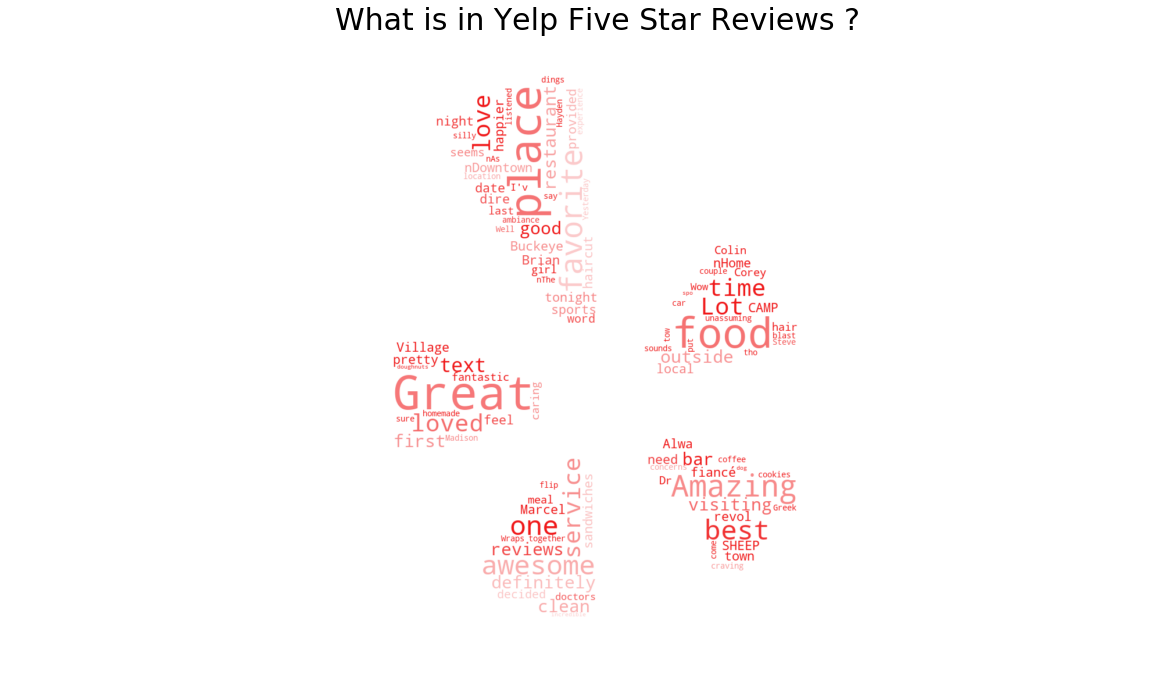

In [101]:
stopwords.update({"Vegas","came","went","think","moved"})
mask=np.array(Image.open("yelp.jpeg"))
image_colors=ImageColorGenerator(mask)
wc=WordCloud(background_color='white',max_words=100,mask=mask, stopwords=stopwords)
wc.generate(str(fivestar_review))
plt.figure(figsize=[20,20])
plt.imshow(wc.recolor(color_func=image_colors),interpolation='bilinear')
plt.axis("off")
plt.title("What is in Yelp Five Star Reviews ?",fontdict={'fontsize':30})

Text(0.5, 1.0, 'What is in Yelp One Star Reviews ?')

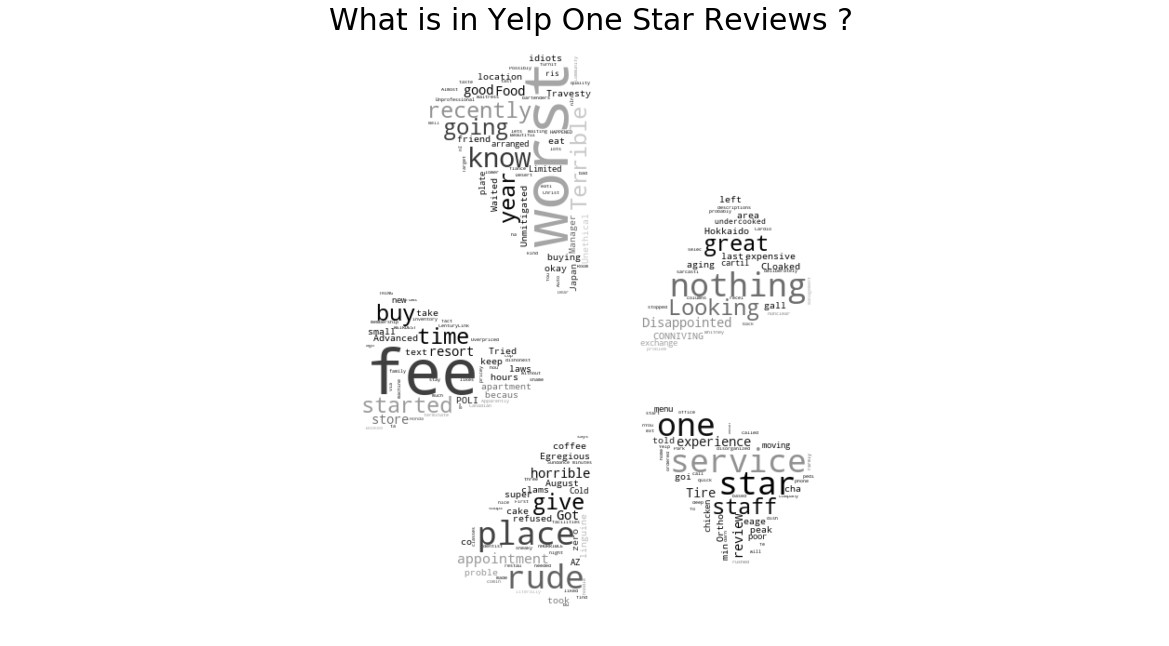

In [105]:
mask =np.array(Image.open("yelp.png"))
image_colors=ImageColorGenerator(mask)
wc=WordCloud(background_color='white',max_words=1000,mask=mask, stopwords=stopwords)
wc.generate(str(onestar_review))
plt.figure(figsize=[20,20])
plt.imshow(wc.recolor(color_func=image_colors),interpolation='bilinear')
plt.axis("off")
plt.title("What is in Yelp One Star Reviews ?",fontdict={'fontsize':30})

In [110]:
sentiment=pd.read_csv("df_complete.csv",header=0)

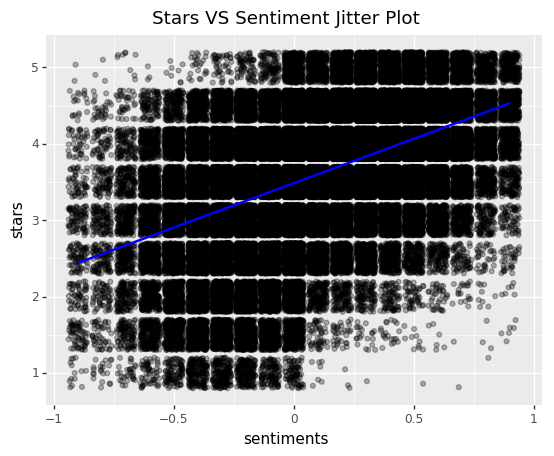

<ggplot: (7587134244)>

In [180]:
p9.ggplot(sentiment,p9.aes(y="stars",x="sentiments"))+p9.geom_point(position="jitter",alpha=0.3)\
    +p9.geom_smooth(color='b')+p9.labs(title="Stars VS Sentiment Jitter Plot")\
    +p9.scale_color_manual(values=['r'],name="h")

In [182]:
business.head()

,business_id,address,categories,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,Apn5Q_b6Nz61Tq4XzPdf9A,1314 44 Avenue NE,Restaurants,Calgary,1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB
1,AjEbIBw6ZFfln7ePHha9PA,NaN,Restaurants,Henderson,0,35.960734,-114.939821,CK'S BBQ & Catering,NaN,89002,3,4.5,NV
2,O8S5hYJ1SMc8fA4QBtVujA,1335 rue Beaubien E,Restaurants,Montréal,0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,bFzdJJ3wp3PZssNEsyU23g,211 W Monroe St,FinancialServices,Phoenix,1,33.449999,-112.076979,Geico Insurance,NaN,85003,8,1.5,AZ
4,8USyCYqpScwiNEb58Bt6CA,2005 Alyth Place SE,Shopping,Calgary,1,51.035591,-114.027366,Action Engine,NaN,T2H 0N5,4,2.0,AB


In [ ]:
sorted_count=business.review_count.value_counts(ascending=True).index
p9.ggplot(business,p9.aes("categories"))+p9.geom_bar(fill="C0")+p9.coord_flip()\
    +p9.scale_x_discrete (limits =sorted_cate)+p9.labs(title="Number of Business Per Catergory")\
    +p9.scale_y_continuous(expand=[0,0],limits=[0,60000])

In [183]:
sorted_rcount=business.review_count.value_counts(ascending=True).index

In [202]:
top_10_count=business.sort_values("review_count")

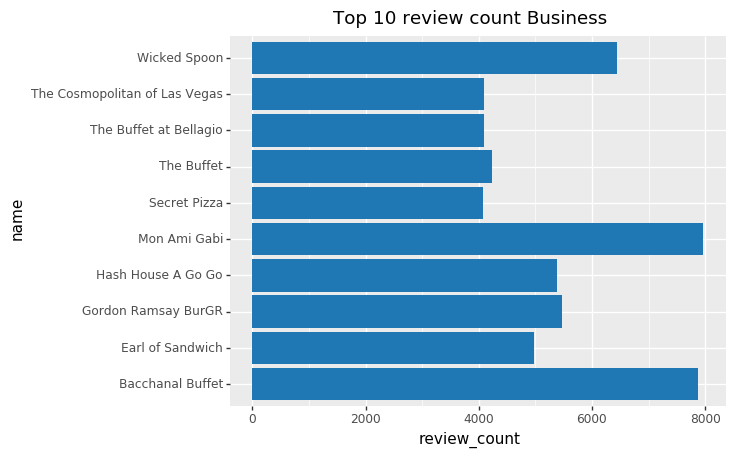

<ggplot: (7606363603)>

In [213]:

p9.ggplot(top_10_count,p9.aes(x="name",y="review_count"))+p9.geom_bar(stat="identity",fill="C0")+p9.coord_flip()\
    +p9.labs(title="Top 10 review count Business")

In [209]:
business=pd.read_sql_table("business",conn)
top_10_count=business.sort_values("review_count",ascending=False)[0:10]

In [212]:
top_10_count

,business_id,address,categories,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
137635,4JNXUYY8wbaaDmk3BPzlWw,3655 Las Vegas Blvd S,"Steakhouses, Breakfast & Brunch, Restaurants, ...",Las Vegas,1,36.112827,-115.172581,Mon Ami Gabi,The Strip,89109,7968,4.0,NV
185167,RESDUcs7fIiihp38-d6_6g,3570 S Las Vegas Blvd,"Sandwiches, Buffets, Breakfast & Brunch, Food,...",Las Vegas,1,36.116113,-115.176222,Bacchanal Buffet,The Strip,89109,7866,4.0,NV
62723,K7lWdNUhCbcnEvI0NhGewg,3708 Las Vegas Blvd S,"Buffets, Restaurants, Breakfast & Brunch",Las Vegas,1,36.109550,-115.176155,Wicked Spoon,The Strip,89109,6446,3.5,NV
188309,cYwJA2A6I12KNkm2rtXd5g,3667 Las Vegas Blvd S,"Burgers, American (Traditional), Restaurants",Las Vegas,0,36.110724,-115.172169,Gordon Ramsay BurGR,The Strip,89109,5472,4.0,NV
170129,f4x1YBxkLrZg652xt2KR5g,3535 Las Vegas Blvd,"Breakfast & Brunch, American (New), Restaurants",Las Vegas,1,36.118181,-115.171580,Hash House A Go Go,The Strip,89109,5382,4.0,NV
177573,DkYS3arLOhA8si5uUEmHOw,3667 Las Vegas Blvd S,"Sandwiches, Wraps, Food, Caterers, Restaurants...",Las Vegas,1,36.109443,-115.171869,Earl of Sandwich,The Strip,89109,4981,4.5,NV
181524,2weQS-RnoOBhb1KsHKyoSQ,3131 Las Vegas Blvd S,"Restaurants, Buffets",Las Vegas,1,36.126887,-115.165590,The Buffet,The Strip,89109,4240,3.5,NV
116244,5LNZ67Yw9RD6nf4_UhXOjw,3708 Las Vegas Blvd S,"Event Planning & Services, Casinos, Hotels, Ar...",Las Vegas,1,36.109755,-115.173877,The Cosmopolitan of Las Vegas,The Strip,89109,4097,4.0,NV
135008,ujHiaprwCQ5ewziu0Vi9rw,3600 S Las Vegas Blvd,"Buffets, American (New), Restaurants",Las Vegas,1,36.113220,-115.176890,The Buffet at Bellagio,The Strip,89109,4091,3.5,NV
180795,iCQpiavjjPzJ5_3gPD5Ebg,3708 Las Vegas Blvd S,"Pizza, Restaurants",Las Vegas,1,36.109837,-115.174212,Secret Pizza,The Strip,89109,4078,4.0,NV


In [214]:
map_data

,business_id,address,categories,city,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,Apn5Q_b6Nz61Tq4XzPdf9A,1314 44 Avenue NE,Restaurants,Calgary,1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB
1,AjEbIBw6ZFfln7ePHha9PA,NaN,Restaurants,Henderson,0,35.960734,-114.939821,CK'S BBQ & Catering,NaN,89002,3,4.5,NV
2,O8S5hYJ1SMc8fA4QBtVujA,1335 rue Beaubien E,Restaurants,Montréal,0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,bFzdJJ3wp3PZssNEsyU23g,211 W Monroe St,FinancialServices,Phoenix,1,33.449999,-112.076979,Geico Insurance,NaN,85003,8,1.5,AZ
4,8USyCYqpScwiNEb58Bt6CA,2005 Alyth Place SE,Shopping,Calgary,1,51.035591,-114.027366,Action Engine,NaN,T2H 0N5,4,2.0,AB
5,45bWSZtniwPRiqlivpS8Og,"20235 N Cave Creek Rd, Ste 1115",Food,Phoenix,1,33.671375,-112.030017,The Coffee Bean & Tea Leaf,NaN,85024,63,4.0,AZ
6,9A2quhZLyWk0akUetBd8hQ,631 Bloor St W,Food,Toronto,0,43.664378,-79.414424,Bnc Cake House,Koreatown,M6G 1K8,7,4.0,ON
7,6OuOZAok8ikONMS_T3EzXg,"3417 Derry Road E, Unit 103",Restaurants,Mississauga,1,43.712946,-79.632763,Thai One On,Ridgewood,L4T 1A8,7,2.0,ON
8,8-NRKkPY1UiFXW20WXKiXg,1440 N. Dysart Ave,Restaurants,Avondale,1,33.448106,-112.341302,Filiberto's Mexican Food,NaN,85323,40,2.5,AZ
9,UTm5QZThPQlT35mkAcGOjg,209 Oakland Ave,Shopping,Pittsburgh,1,40.441421,-79.956457,Maggie & Stella's Gifts,Oakland,15213,3,3.5,PA


In [216]:
map_data=business[business["longitude"].notnull() & business["latitude"].notnull()]
grouped_city=map_data[map_data["city"].notnull()].groupby("city")
def get_outlier(data):
    data.reset_index(drop=True,inplace=True)
    if len(data.index)>=10:
        number_neighbors=round(len(data.index)/10)
    elif len(data.index)<=2:
        data["outlier"]=1
        return data
    else:
        number_neighbors=len(data.index)
    LOF = LocalOutlierFactor(n_neighbors=number_neighbors,metric="euclidean",contamination=0.0004)
    outlier=pd.DataFrame(LOF.fit_predict(data[["latitude","longitude"]]))
    data.reset_index(inplace=True,drop=True)
    data["outlier"]=outlier
    data.index.name=None
    return data
map_data=grouped_city.apply(get_outlier)

In [219]:
sum(map_data.outlier==-1)

612

In [221]:
len(business.index)

188593